# Retrieve Modeled and Observed Snow Data

Author: **Irene Garousi-Nejad** <br>
Last updated: **05/16/2024**

**Introduction**: This notebook is divided into three main sections, each demonstrating how to retrieve snow water equivalent (SWE) data from different sources. The first section covers the retrieval of observed SWE data from SNOTEL sites. The second section focuses on obtaining retrospective SWE data from the National Water Model (NWM) version 3. The third section details how to access modeled SWE results from the WRF-Hydro model simulation. To run the following code cells successfully, ensure that the **getData.py** module is available in the same directory as this notebook.

Define the following parameters

In [1]:
# path to the watershed/domain shapefile
domain_shp = "./BearRiverWBD-Huc8-16010203.shp"

# path to NWM snow data
conus_bucket_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/ldasout.zarr'

# start and end times represented as years
StartDate = '2014-10-01'
EndDate = '2016-09-30'

# path to save retrieved snotel data
SNOTEL_OutputFolder = './snotel_outputs'

# path to save results from NWM
NWM_OutputFolder = './nwm_outputs'

# path to save results form WRF-Hydro
WRFHydro_OutputFolder = './wrfhydro_outputs'

Import required libraries

In [2]:
import os
import glob
os.environ['USE_PYGEOS'] = '0' # to use the default shapely library
import folium
import geopandas as gpd
import pandas as pd
import getData
from shapely.geometry import box, Polygon

import datetime
import s3fs
import boto3
import fsspec
import numpy as np
import xarray as xr
import zarr
import glob
import rasterio
import pyproj
import matplotlib.pyplot as plt

## Observed SWE Data from SNOTEL Sites

### 1. Calculate the number of SNOTEL sites within a spatial domain

In [3]:
# Create geodataframe of all stations
all_stations_gdf = gpd.read_file('https://raw.githubusercontent.com/egagli/snotel_ccss_stations/main/all_stations.geojson').set_index('code')
all_stations_gdf = all_stations_gdf[all_stations_gdf['csvData']==True]
filtered_all_stations_gdf = all_stations_gdf[all_stations_gdf.index.str.contains('_SNTL')]  # only select SNOTEL sites

# Extract the bounding box coordinates of a watershed
domain_gdf = gpd.read_file(domain_shp).to_crs(epsg=4326)

# Use the polygon geometry to select snotel sites that are within the domain
gdf_in_bbox = filtered_all_stations_gdf[filtered_all_stations_gdf.geometry.within(domain_gdf.geometry[0])]
print(f'There are {len(gdf_in_bbox)} sites within the domain')

There are 7 sites within the domain


In [4]:
# plot data on a map

# Calculate the bounds to set the map's initial view
minx, miny, maxx, maxy = gdf_in_bbox.total_bounds

# Calculate the center of the bounding box
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2

# Convert GeoDataFrames to GeoJSON
geojson1 = gdf_in_bbox.astype(dict(beginDate=str, endDate=str)).to_json()
geojson2 = domain_gdf.to_json()

# Create a folium map
m = folium.Map([center_lat, center_lon], zoom_start=10)

# Add GeoJSON layers for each GeoDataFrame to the map
folium.GeoJson(geojson1, name='GeoDataFrame 1').add_to(m)
folium.GeoJson(geojson2, name='GeoDataFrame 2').add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Display the map
m

In [5]:
gdf_in_bbox.reset_index(inplace=True)
gdf_in_bbox

,code,name,network,elevation_m,latitude,longitude,state,HUC,mgrs,mountainRange,beginDate,endDate,csvData,geometry
0,455_UT_SNTL,Dry Bread Pond,SNOTEL,2530.449707,41.412891,-111.537697,Utah,160102030101,12TVL,Western Rocky Mountains,1978-10-01,2024-05-15,True,POINT (-111.53770 41.41289)
1,1115_UT_SNTL,Klondike Narrows,SNOTEL,2209.800049,41.967690,-111.597130,Utah,160102030302,12TVM,Western Rocky Mountains,2009-10-01,2024-05-15,True,POINT (-111.59713 41.96769)
2,582_UT_SNTL,Little Bear,SNOTEL,1995.830444,41.405621,-111.826073,Utah,160102030103,12TVL,Western Rocky Mountains,1978-10-01,2024-05-14,True,POINT (-111.82607 41.40562)
3,634_UT_SNTL,Monte Cristo,SNOTEL,2722.473633,41.465469,-111.496880,Utah,160102030201,12TVL,Western Rocky Mountains,1978-10-01,2024-05-15,True,POINT (-111.49688 41.46547)
4,1013_UT_SNTL,Temple Fork,SNOTEL,2257.348877,41.792999,-111.546051,Utah,160102030303,12TVM,Western Rocky Mountains,2001-11-05,2024-05-15,True,POINT (-111.54605 41.79300)
5,823_UT_SNTL,Tony Grove Lake,SNOTEL,2582.875244,41.898331,-111.629570,Utah,160102030304,12TVM,Western Rocky Mountains,1978-10-01,2024-05-15,True,POINT (-111.62957 41.89833)
6,1113_UT_SNTL,Tony Grove RS,SNOTEL,1929.993652,41.885731,-111.569183,Utah,160102030304,12TVM,Western Rocky Mountains,2009-10-01,2024-05-15,True,POINT (-111.56918 41.88573)


### 2. Retrieve data for the selected sites

In [6]:
# Create a folder to save results
isExist = os.path.exists(SNOTEL_OutputFolder)
if isExist == True:
    exit
else:
    os.mkdir(SNOTEL_OutputFolder)

In [8]:
# Use the getData module to retrieve data 
for i in gdf_in_bbox.index:
    !python getData.py f'{gdf_in_bbox["name"][i]}' {gdf_in_bbox['code'][i].split('_')[0]} {gdf_in_bbox['code'][i].split('_')[1]} {StartDate} {EndDate} {SNOTEL_OutputFolder}

Start retrieving data for fDry Bread Pond, 455
Start retrieving data for fKlondike Narrows, 1115
Start retrieving data for fLittle Bear, 582
Start retrieving data for fMonte Cristo, 634
Start retrieving data for fTemple Fork, 1013
Start retrieving data for fTony Grove Lake, 823
Start retrieving data for fTony Grove RS, 1113


## Retrospective SWE Data from the National Water Model (NWM) Version 3


In [7]:
import dask
from dask.distributed import Client
from dask.distributed import progress
try:
    print(client.dashboard_link)
except:    
    client = Client(n_workers=24, threads_per_worker=1, memory_limit='2GB') 
    print(client.dashboard_link)

/user/igarousi/proxy/8787/status


In [8]:
# Create a folder to save results
isExist = os.path.exists(NWM_OutputFolder)
if isExist == True:
    exit
else:
    os.mkdir(NWM_OutputFolder)

In [9]:
# load data
%time ds = ds = xr.open_zarr(fsspec.get_mapper(conus_bucket_url, anon=True), consolidated=True)

CPU times: user 6.38 s, sys: 945 ms, total: 7.33 s
Wall time: 10.8 s


The following cell first finds the associated projected coordinates for a SNOTEL site and then retrieves NWM data for that particular location and period of interest. Then, it saves the dataset as a DataFrame and cleans up the columns. Next, it converts the UTC time zone (the time zone that NWM uses) to the local time zone because we want to compare these values with observed data at SNOTEL sites, which are reported in the local time zone.

Next, it groups the data by the specific date and selects the first item from each group. This is required because NWM retrospective results from the land surface model are stored every three hours. To fairly compare these values with the SNOTEL data, which records SWE at the beginning of each day in local time, we need to do this.

We do this instead of just selecting hour 0 because the start of the day in UTC is hour 0, but when we convert to local time, the start hour depends on the time zone. This inconsistency among different regions means that the start hour can vary. To ensure we select the earliest hour of the day in the local time zone, we use this method.

In [55]:
# Retrieve data for the location of snotel sites
input_crs = 'EPSG:4269'
output_crs = pyproj.CRS(ds.crs.esri_pe_string) 

for i in range(0, gdf_in_bbox.shape[0]): 
    
    snotel_y, snotel_x = getData.convert_latlon_to_yx(gdf_in_bbox.iloc[i].latitude, 
                                                      gdf_in_bbox.iloc[i].longitude, input_crs, ds, output_crs)
    
    %time ds_subset = ds[['SNEQV']].sel(y=snotel_y, x=snotel_x, method='nearest').sel(time=slice(StartDate, EndDate)).compute()
    
    df = ds_subset.to_dataframe()
    df=df.drop(columns=['x', 'y'])
    df.reset_index(inplace=True)
    df["time"] = pd.to_datetime(df["time"])
    df.rename(columns={df.columns[0]:'Date', df.columns[1]:'NWM_SWE_meters'}, inplace=True)
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: pd.to_numeric(x)/1000)  # convert mm to m   

    # convert utc to local time zone
    state_abbr = gdf_in_bbox.iloc[0].code.split("_")[1]   # state abbreviation to identify the time zone
    df_local = getData.convert_utc_to_local(state_abbr, df)   
    
    # groupby the data and select the first item from each group 
    df_local.index = pd.to_datetime(df_local['Date_Local'])
    df_local = df_local.groupby(pd.Grouper(freq='D')).first()

    # save
    df_local.to_csv(f'./{NWM_OutputFolder}/df_{gdf_in_bbox.iloc[i].code.split("_")[0]}_{gdf_in_bbox.iloc[i].code.split("_")[1]}_SNTL.csv', index=False)


CPU times: user 570 ms, sys: 140 ms, total: 710 ms
Wall time: 2.68 s
CPU times: user 458 ms, sys: 126 ms, total: 585 ms
Wall time: 2.48 s
CPU times: user 520 ms, sys: 133 ms, total: 653 ms
Wall time: 2.84 s
CPU times: user 482 ms, sys: 113 ms, total: 595 ms
Wall time: 2.55 s
CPU times: user 564 ms, sys: 137 ms, total: 701 ms
Wall time: 2.79 s
CPU times: user 469 ms, sys: 137 ms, total: 606 ms
Wall time: 2.66 s
CPU times: user 520 ms, sys: 134 ms, total: 654 ms
Wall time: 2.66 s


Check point

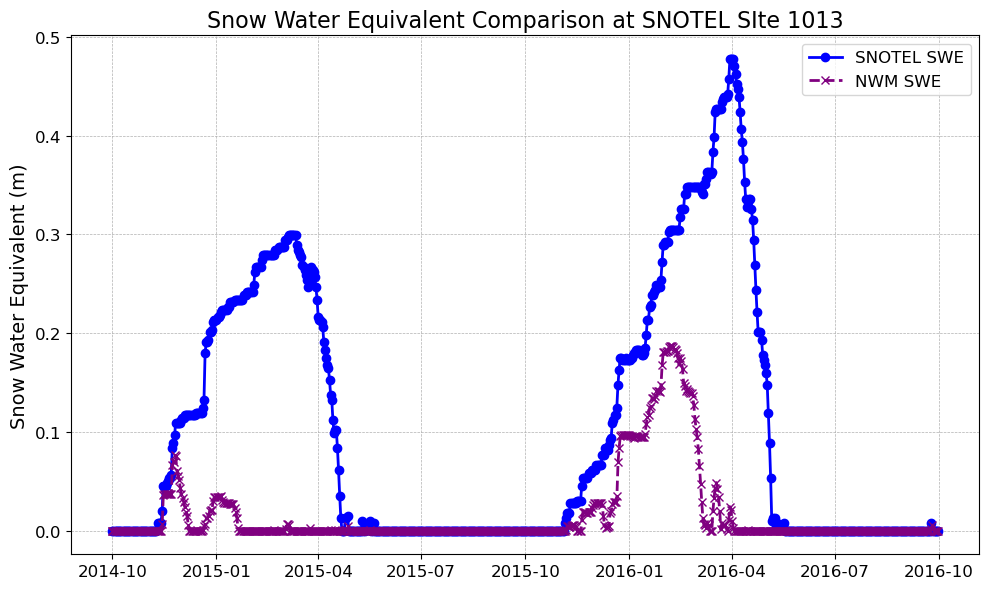

In [56]:
snotel = pd.read_csv('./snotel_outputs/df_1013_UT_SNTL.csv')
nwm = pd.read_csv('./nwm_outputs/df_1013_UT_SNTL.csv')

# Convert Date columns to datetime
snotel['Date'] = pd.to_datetime(snotel['Date'])
nwm['Date_Local'] = pd.to_datetime(nwm['Date_Local'])

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(snotel['Date'], snotel['Snow Water Equivalent (m) Start of Day Values'], 
         color='b', label='SNOTEL SWE', linewidth=2, marker='o')
plt.plot(nwm['Date_Local'], nwm['NWM_SWE_meters'], color='purple', 
         linestyle='--', label='NWM SWE', linewidth=2, marker='x')

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Label the axes
plt.ylabel('Snow Water Equivalent (m)', fontsize=14)

# Set the title
plt.title(f'Snow Water Equivalent Comparison at SNOTEL SIte 1013', fontsize=16)

# Show the legend
plt.legend(fontsize=12)

# Improve the appearance of the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Combine all data

In this section, we combine the retrieved data from all sources into a single CSV file.

In [11]:
snotel_files = glob.glob(os.path.join(SNOTEL_OutputFolder, '*.csv'))
nwm_files = glob.glob(os.path.join(NWM_OutputFolder, '*.csv'))

# call the function from the getData library
combined_df = getData.combine(snotel_files, nwm_files, StartDate, EndDate)

# save
combined_df.to_csv(f'./snow_comparison_data.csv', index=False)

In [20]:
# print(snotel.shape[0], nwm.shape[0], combined_df.shape[0])
combined_df.columns

Index(['snotel_634_swe_m', 'snotel_455_swe_m', 'snotel_582_swe_m',
       'snotel_1113_swe_m', 'snotel_1115_swe_m', 'snotel_823_swe_m',
       'snotel_1013_swe_m', 'nwm_634_swe_m', 'nwm_455_swe_m', 'nwm_582_swe_m',
       'nwm_1113_swe_m', 'nwm_1115_swe_m', 'nwm_823_swe_m', 'nwm_1013_swe_m'],
      dtype='object')

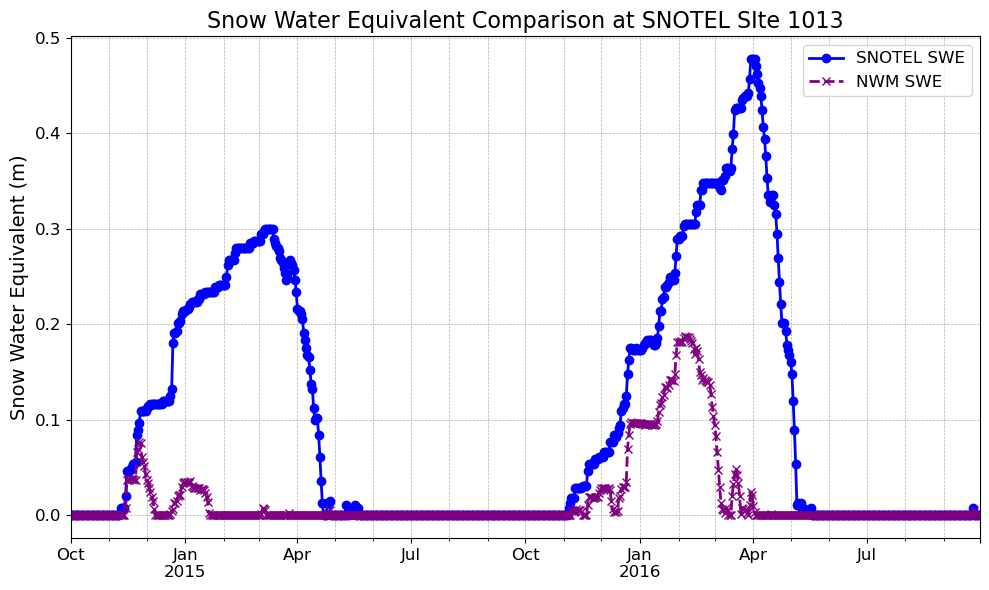

In [23]:
# Plot the data
plt.figure(figsize=(10, 6))

combined_df['snotel_1013_swe_m'].plot(color='b', label='SNOTEL SWE', linewidth=2, marker='o')
combined_df['nwm_1013_swe_m'].plot(color='purple', linestyle='--', label='NWM SWE', linewidth=2, marker='x')

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Label the axes
plt.ylabel('Snow Water Equivalent (m)', fontsize=14)

# Set the title
plt.title(f'Snow Water Equivalent Comparison at SNOTEL SIte 1013', fontsize=16)

# Show the legend
plt.legend(fontsize=12)

# Improve the appearance of the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Modeled SWE Results from the WRF-Hydro Model Simulation